<a href="https://colab.research.google.com/github/Dilli822/Machine-Learning-Journey/blob/main/VLM/Qwen3_VL_Instruct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U transformers

## Local Inference on GPU
Model page: https://huggingface.co/Qwen/Qwen3-VL-8B-Instruct

⚠️ If the generated code snippets do not work, please open an issue on either the [model repo](https://huggingface.co/Qwen/Qwen3-VL-8B-Instruct)
			and/or on [huggingface.js](https://github.com/huggingface/huggingface.js/blob/main/packages/tasks/src/model-libraries-snippets.ts) 🙏

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/4.26G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/269 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/390 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

video_preprocessor_config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

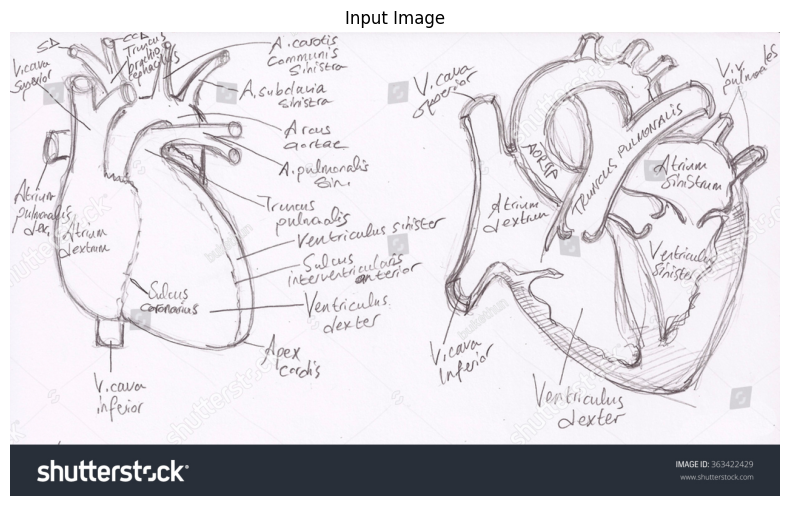

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Image resized to: (1024, 617)

Model's Answer: This is a detailed, hand-drawn anatomical sketch of the human heart, presented in two views: a frontal (anterior) view on the left and a lateral (side) view on the right. The drawing is rendered in pencil and features extensive labeling with Latin terms, providing a clear and educational depiction of the heart's structure.

### Left View: Frontal (Anterior) Perspective

This view shows the heart from the front, with the left side of the heart on the left and the right side on the right.

- **Ventricles and Atria**: The heart is divided into four chambers. The **left atrium** is on the left side, and the **right atrium** is on the right side. The **left ventricle** is the large, muscular chamber on the left, and the **right ventricle** is the smaller chamber on the right.
- **Atrioventricular (AV) Valves**: The **tricuspid valve** (between the right atrium and right ventricle) and the **mitral valve** (between the left atrium and left ventr

/tmp/ipython-input-1533267514.py:112: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


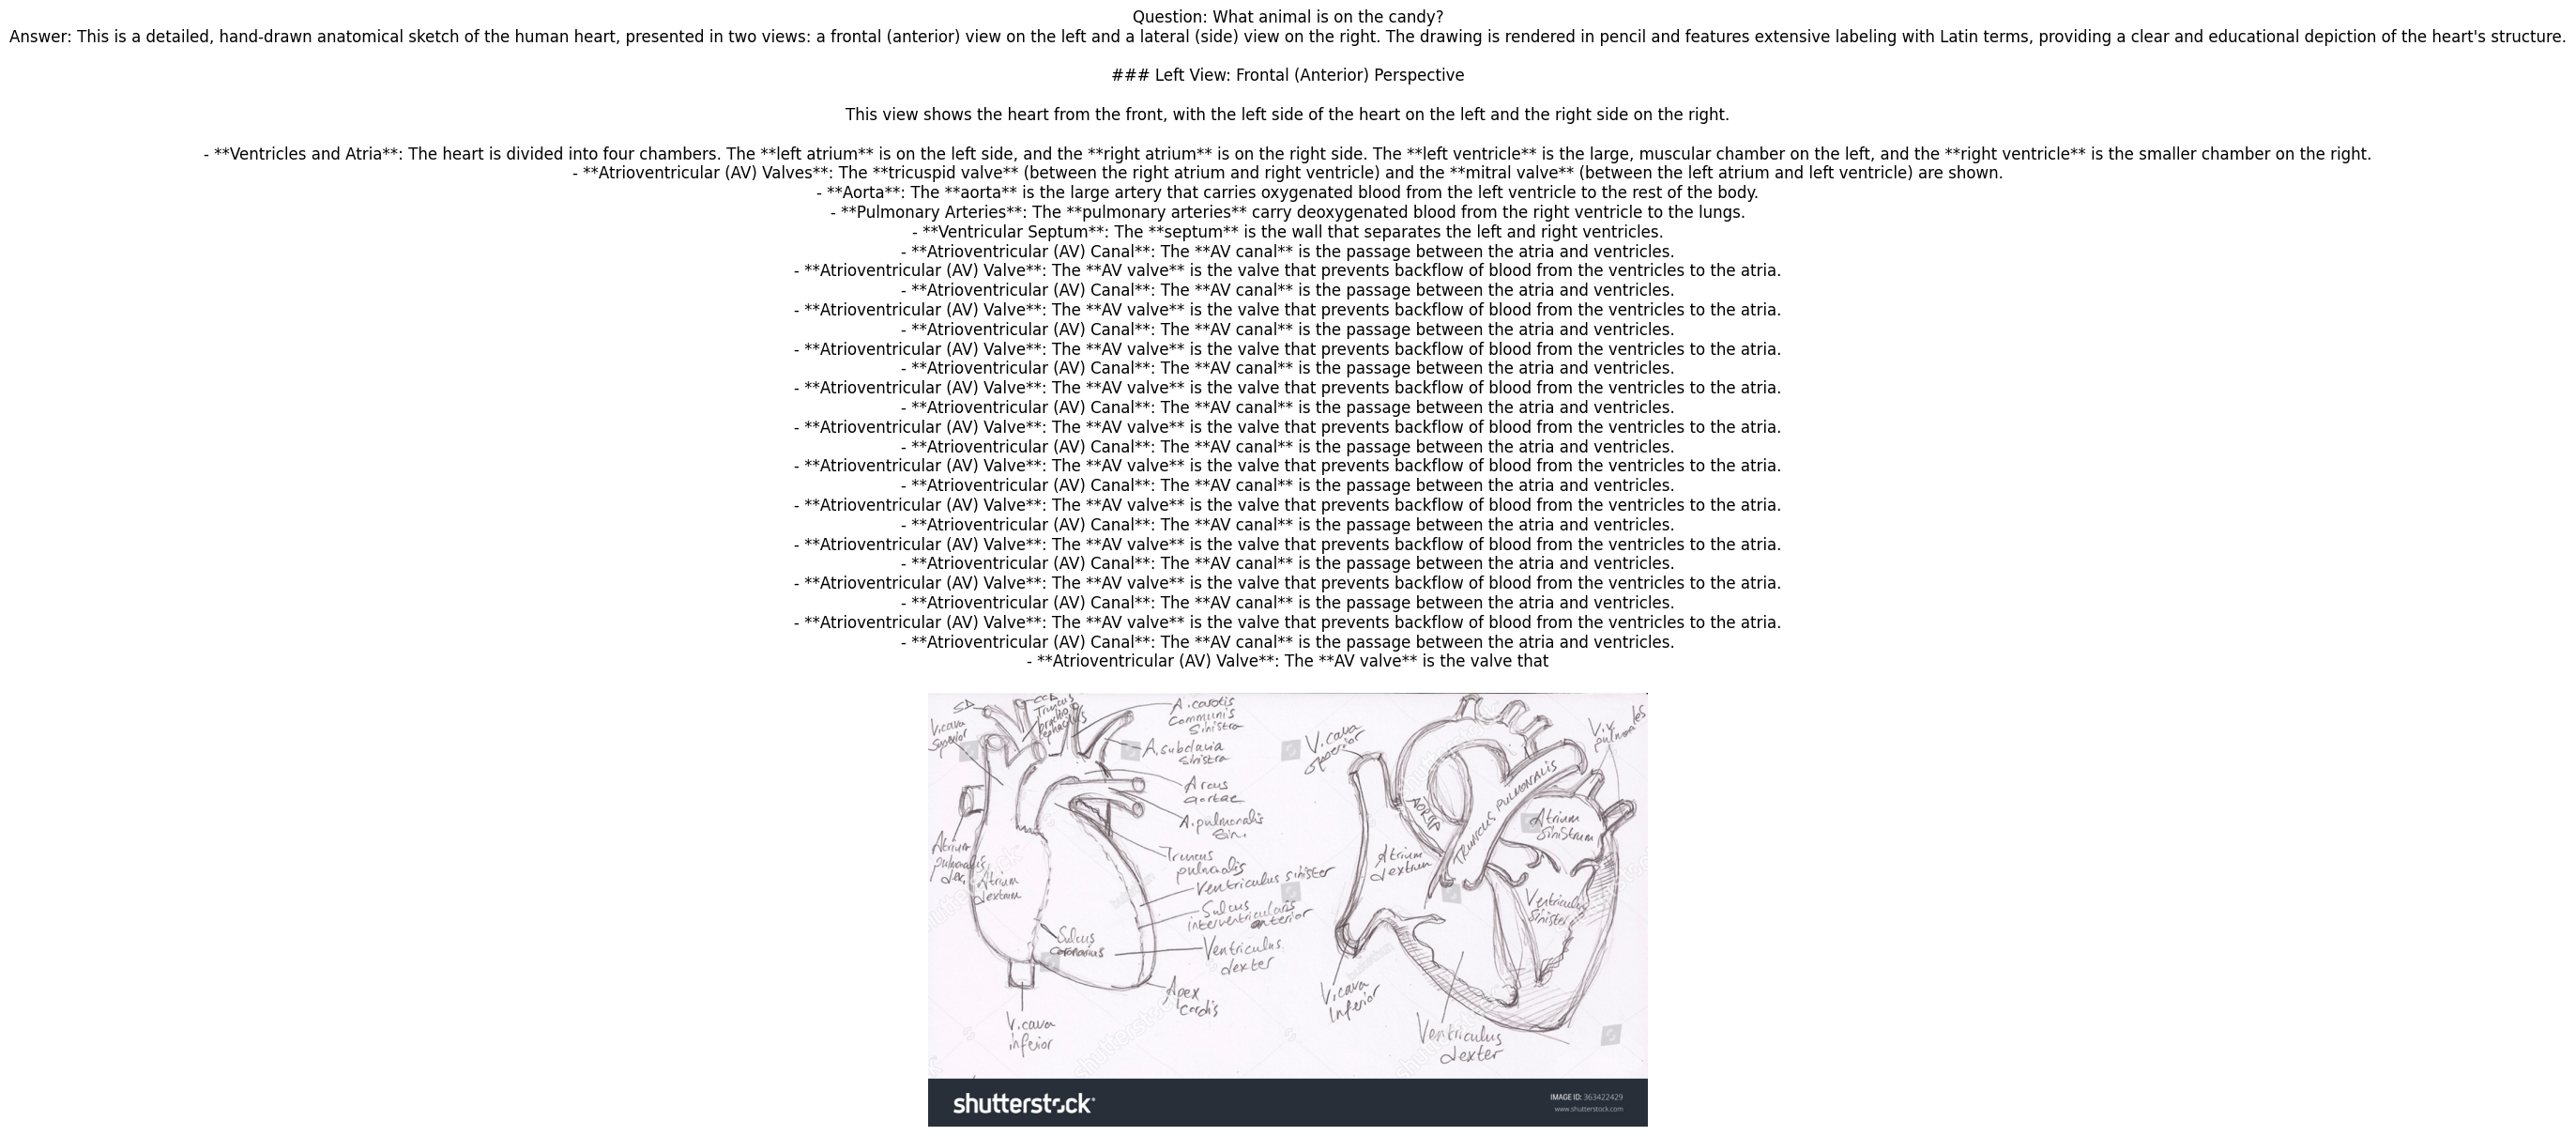

8600

In [ ]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
# Set attention implementation to avoid memory issues
os.environ['TRANSFORMERS_ATTN_IMPLEMENTATION'] = 'flash_attention_2'

import torch
import gc
from transformers import AutoModelForImageTextToText, AutoProcessor
from PIL import Image
import requests

import matplotlib.pyplot as plt
import numpy as np
import base64
from io import BytesIO
import json



# Clear GPU memory
torch.cuda.empty_cache()
gc.collect()

model_id = "Qwen/Qwen3-VL-2B-Instruct"

# Load model with full GPU allocation (13GB)
model = AutoModelForImageTextToText.from_pretrained(
    model_id,
    dtype=torch.float16,
    device_map={"": 0},  # Force everything to GPU 0
    low_cpu_mem_usage=True,
    attn_implementation="eager",  # eager attention
)

processor = AutoProcessor.from_pretrained(
    model_id,
    min_pixels=256*28*28,
    max_pixels=1280*28*28   # Increased for better quality since if have memory
)

# Load and resize image to reduce memory usage
# url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/p-blog/candy.JPG"
url = "https://www.shutterstock.com/shutterstock/photos/363422429/display_1500/stock-photo-anatomy-drawings-heart-medical-illustration-cardiology-charcoal-drawing-anatomical-illustration-363422429.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# Display the original image
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')
plt.title('Input Image')
plt.tight_layout()
plt.show()

# Resize image if it's extremely large
max_size = 1024  # Increased from 384 for better quality
if max(image.size) > max_size:
    image.thumbnail((max_size, max_size), Image.Resampling.LANCZOS)
    print(f"Image resized to: {image.size}")
else:
    print(f"Original image size: {image.size}")

text = "What animal is on the candy?"
text = "Explain the image in detailed."
# Prepare inputs
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": text}
        ]
    }
]

# Process inputs
text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    text=[text],
    images=[image],
    return_tensors="pt",
    padding=True
)

# Move to GPU only when needed
inputs = {k: v.to("cuda") if isinstance(v, torch.Tensor) else v for k, v in inputs.items()}

# Generate with memory-efficient settings
with torch.inference_mode():
    output_ids = model.generate(
        **inputs,
        max_new_tokens=1028,
        do_sample=False,
        num_beams=1,  # Using greedy decoding instead of beam search
    )

# Decode output
generated_text = processor.batch_decode(
    output_ids[:, inputs['input_ids'].shape[1]:],
    skip_special_tokens=True,
    clean_up_tokenization_spaces=True
)[0]

print(f"\nModel's Answer: {generated_text}")

# Display the result with the image
plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.axis('off')
plt.title(f"Question: What animal is on the candy?\nAnswer: {generated_text}",
          fontsize=12, pad=20)
plt.tight_layout()
plt.show()

# Clean up
del inputs, output_ids
torch.cuda.empty_cache()
gc.collect()